In [11]:
import os
import cv2
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, MaxPooling2D, Flatten,Conv2D,Reshape, Conv1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras import losses
from tensorflow.keras.metrics import Recall, Precision
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import shutil
import sys
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import  preprocess_input
from keras.utils import to_categorical
import os
import cv2 as cv
from sklearn.metrics import roc_auc_score
#import drive
from tensorflow.keras.utils import image_dataset_from_directory
print ('modules loaded')

modules loaded


In [10]:
!pip install seaborn


   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ----- --------------------------------- 41.0/294.9 kB 653.6 kB/s eta 0:00:01
   ---------------- ----------------------- 122.9/294.9 kB 1.2 MB/s eta 0:00:01
   -------------------- ------------------- 153.6/294.9 kB 1.5 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 1.8 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.1.2 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Found 58 files belonging to 2 classes.
Found 196 files belonging to 2 classes.
Found 97 files belonging to 2 classes.


In [19]:
import os
import random
import numpy as np
import tensorflow as tf

class Dataset:

  def __init__(self, dataset_path="Cropped_Rf_data_resolution-20250407T155915Z-001\Cropped_Rf_data_resolution", training=True):
        """
        Load and preprocess a dataset structured like Omniglot using OpenCV.

        :param dataset_path: Path to the dataset containing 'Train' and 'Test' folders.
        :param training: Boolean, determines whether to load training or test data.
        """
        split = "Train" if training else "Test"
        dataset_dir = os.path.join(dataset_path, split)

        self.data = {}

        img_height = 224
        img_width = 224

        # Sort class names and assign consistent labels
        class_names = sorted([
            d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))
        ])
        label_mapping = {class_name: str(i) for i, class_name in enumerate(class_names)}

        # Process images using OpenCV
        for class_name in class_names:
            class_dir = os.path.join(dataset_dir, class_name)
            label = label_mapping[class_name]

            for filename in os.listdir(class_dir):
                if filename.lower().endswith((".png", ".jpg", ".jpeg")):
                    image_path = os.path.join(class_dir, filename)
                    img = cv2.imread(image_path)
                    if img is None:
                        continue  # skip unreadable files
                    img = cv2.resize(img, (img_width, img_height))
                    img = img / 255.0  # normalize
                    if label not in self.data:
                        self.data[label] = []
                    self.data[label].append(img)

        self.labels = list(self.data.keys())

  def get_mini_dataset(
      self, batch_size, repetitions, shots, num_classes, split=False
  ):
      temp_labels = np.zeros(shape=(num_classes * shots))
      temp_images = np.zeros(shape=(num_classes * shots, 224, 224, 3))
      if split:
          test_labels = np.zeros(shape=(num_classes))
          test_images = np.zeros(shape=(num_classes, 224, 224, 3))

      # Get a random subset of labels from the entire label set.
      label_subset = random.choices(self.labels, k=num_classes)
      for class_idx, class_obj in enumerate(label_subset):
          # Use enumerated index value as a temporary label for mini-batch in
          # few shot learning.
          temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx
          # If creating a split dataset for testing, select an extra sample from each
          # label to create the test dataset.
          if split:
              test_labels[class_idx] = class_idx
              images_to_split = random.choices(
                  self.data[label_subset[class_idx]], k=shots + 1
              )
              test_images[class_idx] = images_to_split[-1]
              temp_images[
                  class_idx * shots : (class_idx + 1) * shots
              ] = images_to_split[:-1]
          else:
              # For each index in the randomly selected label_subset, sample the
              # necessary number of images.
              temp_images[
                  class_idx * shots : (class_idx + 1) * shots
              ] = random.choices(self.data[label_subset[class_idx]], k=shots)

      dataset = tf.data.Dataset.from_tensor_slices(
          (temp_images.astype(np.float32), temp_labels.astype(np.int32))
      )
      dataset = dataset.shuffle(100).batch(batch_size).repeat(repetitions)
      if split:

          return dataset, test_images, test_labels
      return dataset
data_dir = "Cropped_Rf_data_resolution-20250407T155915Z-001"
train_dataset = Dataset(training=True)
test_dataset = Dataset(training=False)

<>:8: SyntaxWarning: invalid escape sequence '\C'
<>:8: SyntaxWarning: invalid escape sequence '\C'
C:\Users\alyes\AppData\Local\Temp\ipykernel_12816\1273015838.py:8: SyntaxWarning: invalid escape sequence '\C'
  def __init__(self, dataset_path="Cropped_Rf_data_resolution-20250407T155915Z-001\Cropped_Rf_data_resolution", training=True):


In [21]:
!pip install tensorflow-datasets


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/57.7 kB ? eta -:--:--
     ---------------------------- ----------- 41.0/57.7 kB 1.9 MB/s eta 0:00:01
     ---------------------------------------- 57.7/57.7 kB 1.0 MB/s eta 0:00:00
  Using cached docstring_parser-0.16-py3-none-any.whl.metadata (3.0 kB)
   ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
    --------------------------------------- 0.1/5.3 MB 5.5 MB/s eta 0:00:01
   - -------------------------------------- 0.2/5.3 MB 3.0 MB/s eta 0:00:02
   -- ------------------------------------- 0.4/5.3 MB 3.8 MB/s eta 0:00:02
   ---- ----------------------------------- 0.6/5.3 MB 3.5 MB/s eta 0:00:02
   ----- ---------------------------------- 0.7/5.3 MB 3.9 MB/s eta 0:00:02
   ------ --------------------------------- 0.9/5.3 MB 3.6 MB/s eta 0:00:02
   -------- ------------------------------- 1.1/5.3 MB 3.8 MB/s eta 0


[notice] A new release of pip is available: 24.1.2 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import layers

import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
import tensorflow_datasets as tfds

In [23]:
learning_rate = 0.003
meta_step_size = 0.25

inner_batch_size = 25
eval_batch_size = 25

meta_iters = 500
eval_iters = 5
inner_iters = 4

eval_interval = 1
train_shots = 20
shots = 5
classes = 4

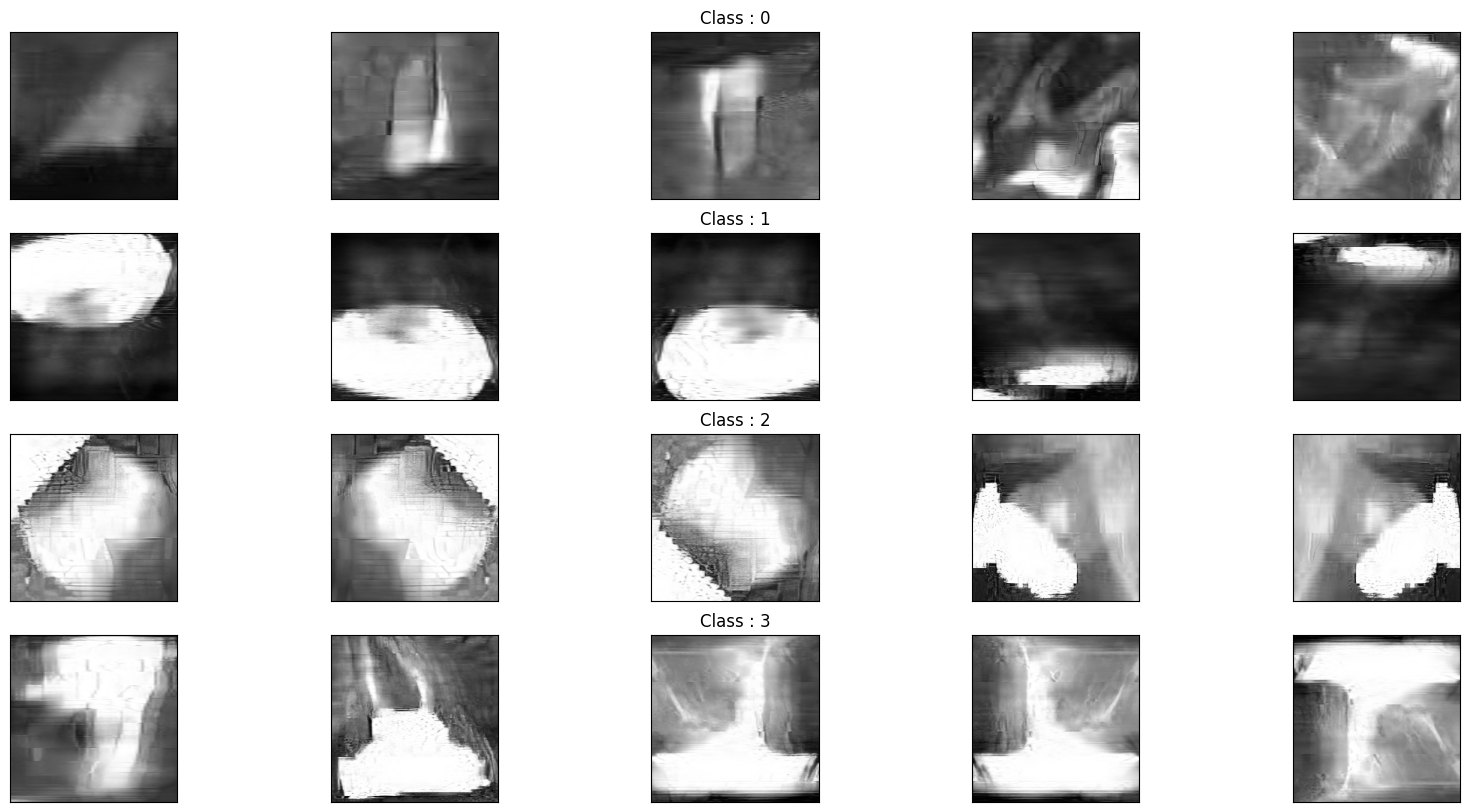

In [24]:
_, axarr = plt.subplots(nrows=4, ncols=5, figsize=(20, 10))

sample_keys = list(train_dataset.data.keys())

for a in range(4):
    for b in range(5):
        temp_image = train_dataset.data[sample_keys[a]][b]
        temp_image = np.stack((temp_image[:, :, 0],) * 3, axis=2)
        temp_image *= 255
        temp_image = np.clip(temp_image, 0, 255).astype("uint8")
        if b == 2:
            axarr[a, b].set_title("Class : " + sample_keys[a])
        axarr[a, b].imshow(temp_image, cmap="gray")
        axarr[a, b].xaxis.set_visible(False)
        axarr[a, b].yaxis.set_visible(False)
plt.show()

In [26]:
!pip install keras-tuner --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.5 MB/s eta 0:00:00


In [25]:
from tensorflow.keras import layers, models, regularizers, optimizers

# Define image shape and number of classes
img_shape = (224, 224, 3)
num_classes = 4
learning_rate = 0.01

# Build the CNN model using Sequential API
model = models.Sequential([
    # Convolutional + Pooling Layers
    layers.Conv2D(144, (3, 3), activation='relu', input_shape=img_shape),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(192, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(176, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(208, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(192, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten, Dropout, and Dense Layers
    layers.Flatten(),
    layers.Dropout(0.3),

    layers.Dense(144, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(192, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(176, activation='relu', kernel_regularizer=regularizers.l2(0.001)),

    # Output Layer
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
optimizer = optimizers.SGD(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Summary (optional for debugging)
model.summary()


c:\Users\alyes\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 144)  │         4,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 144)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 192)  │       249,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 176)    │       304,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 176)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 208)    │       329,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 208)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 192)    │       359,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 144)            │       691,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 192)            │        27,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 176)            │        33,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           708 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,516 (7.63 MB)

 Trainable params: 2,000,516 (7.63 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
training = []
testing = []
for meta_iter in range(meta_iters):
    frac_done = meta_iter / meta_iters
    cur_meta_step_size = (1 - frac_done) * meta_step_size
    # Temporarily save the weights from the model.
    old_vars = model.get_weights()
    # Get a sample from the full dataset.
    mini_dataset = train_dataset.get_mini_dataset(
        inner_batch_size, inner_iters, train_shots, classes
    )
    for images, labels in mini_dataset:
        with tf.GradientTape() as tape:
            preds = model(images)
            #labels = tf.expand_dims(labels, axis=-1)
            loss =keras.losses.sparse_categorical_crossentropy(labels, preds)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
    new_vars = model.get_weights()
    # Perform SGD for the meta step.
    for var in range(len(new_vars)):
        new_vars[var] = old_vars[var] + (
            (new_vars[var] - old_vars[var]) * cur_meta_step_size
        )
    # After the meta-learning step, reload the newly-trained weights into the model.
    model.set_weights(new_vars)
    # Evaluation loop
    if meta_iter % eval_interval == 0:
        accuracies = []
        for dataset in (train_dataset, test_dataset):
            # Sample a mini dataset from the full dataset.
            train_set, test_images, test_labels = dataset.get_mini_dataset(
                eval_batch_size, eval_iters, shots, classes, split=True
            )
            old_vars = model.get_weights()
            # Train on the samples and get the resulting accuracies.
            for images, labels in train_set:
                with tf.GradientTape() as tape:
                    preds = model(images)
                    loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
                grads = tape.gradient(loss, model.trainable_weights)
                optimizer.apply_gradients(zip(grads, model.trainable_weights))
            test_preds = model.predict(test_images)
            test_preds = tf.argmax(test_preds).numpy()
            num_correct = (test_preds == test_labels).sum()
            # Reset the weights after getting the evaluation accuracies.
            model.set_weights(old_vars)
            accuracies.append(num_correct / classes)
        training.append(accuracies[0])
        testing.append(accuracies[1])
        print(
                "batch %d: train=%f test=%f" % (meta_iter, accuracies[0], accuracies[1])
            )
        if meta_iter % 100 == 0:
            print(
                "batch %d: train=%f test=%f" % (meta_iter, accuracies[0], accuracies[1])
            )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
batch 0: train=0.000000 test=0.250000
batch 0: train=0.000000 test=0.250000


KeyboardInterrupt: 

In [ ]:
test_labels.shape


(2,)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[0.48638319 0.48678842 0.48667456 ... 0.55932405 0.55752266 0.55502834] [[0.25924855 0.25808206 0.24374776 0.23892167]
 [0.2590971  0.26183775 0.2424513  0.23661385]
 [0.25902498 0.25863475 0.24380596 0.23853432]
 [0.2594861  0.25900748 0.24330863 0.23819776]] 4


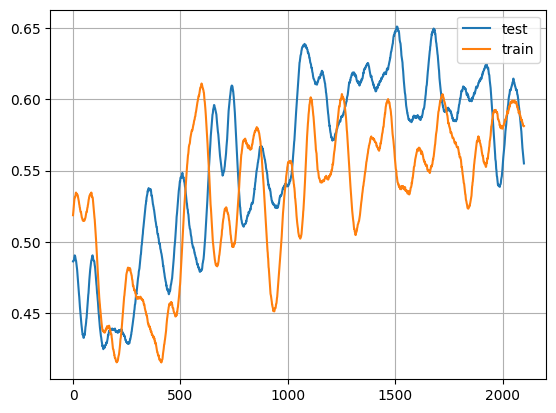

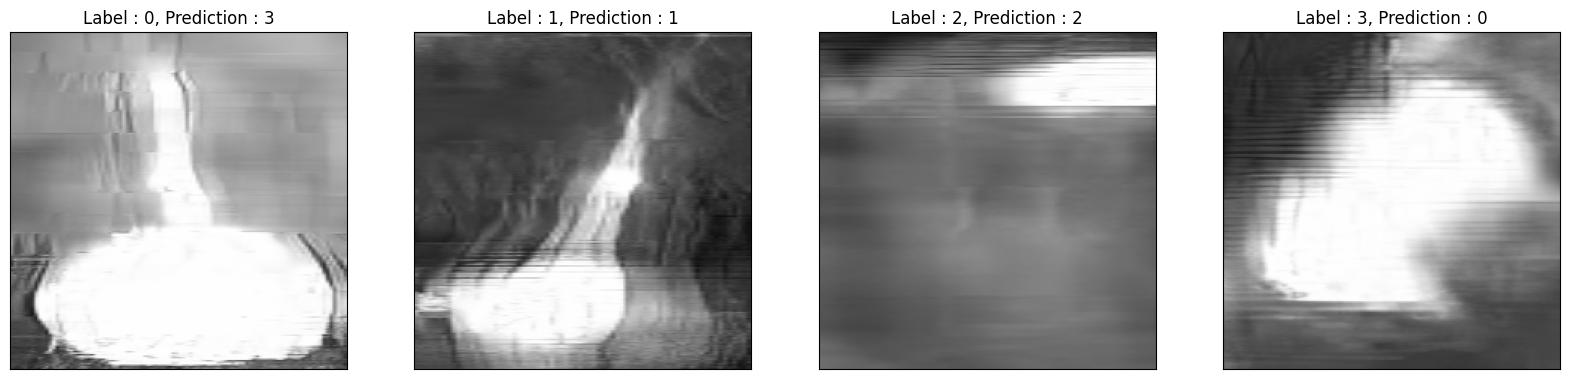

In [ ]:
window_length = 100
train_s = np.r_[
    training[window_length - 1 : 0 : -1],
    training,
    training[-1:-window_length:-1],
]
test_s = np.r_[
    testing[window_length - 1 : 0 : -1], testing, testing[-1:-window_length:-1]
]
w = np.hamming(window_length)
train_y = np.convolve(w / w.sum(), train_s, mode="valid")
test_y = np.convolve(w / w.sum(), test_s, mode="valid")

# Display the training accuracies.
x = np.arange(0, len(test_y), 1)
plt.plot(x, test_y, x, train_y)
plt.legend(["test", "train"])
plt.grid()

train_set, test_images, test_labels = dataset.get_mini_dataset(
    eval_batch_size, eval_iters, shots, classes, split=True
)
for images, labels in train_set:
    with tf.GradientTape() as tape:
        preds = model(images)
        labels = tf.expand_dims(labels, axis=-1)
        loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
test_preds = model.predict(test_images)
print(test_y,test_preds,len(test_images))
test_preds = tf.argmax(test_preds).numpy()
num_correct = np.sum(test_preds == test_labels)

# Calculate test accuracy
test_accuracy = num_correct / len(test_labels) * 100

# Print test accuracy


_, axarr = plt.subplots(nrows=1, ncols=4, figsize=(20, 20))

sample_keys = list(train_dataset.data.keys())

for i, ax in zip(range(4), axarr):
    temp_image = np.stack((test_images[i, :, :, 0],) * 3, axis=2)
    temp_image *= 255
    temp_image = np.clip(temp_image, 0, 255).astype("uint8")
    ax.set_title(
        "Label : {}, Prediction : {}".format(int(test_labels[i]), test_preds[i])
    )
    ax.imshow(temp_image, cmap="gray")
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.show()

In [ ]:
from IPython.display import display
import ipywidgets as widgets
from PIL import Image
import numpy as np
from tensorflow.keras.models import load_model
from IPython.display import display, HTML
import cv2
# Load the pre
def predict_tumor(image):
    # Resize the image to the input shape required by the model
    image =cv2.imread(image)
    image = Image.fromarray(image).resize((224, 224))
    # Convert the image to a numpy array and normalize it
    image_array = np.array(image) / 255.0
    # Ensure the image has 3 channels (RGB), if not convert it

    # Reshape the image to match the model's input shape
    image_array = image_array.reshape(-1,224, 224, 3)
    # Predict the class using the model
    predictions = model.predict(image_array)
    print(predictions)
    # Get the index of the highest prediction
    predicted_class_index = np.argmax(predictions)
    # Get the class name
    predicted_class = class_names[predicted_class_index]
    return f"Predicted Tumor Class: {predicted_class}"
image_path='/content/drive/MyDrive/Cropped_Rf_data_resolution/Test/3/0010_jpg.rf.fc353845a6614b0ad4a0b407f3b5bbdf_tooth_3_rlt.png'
class_names = ['demale','male',"0","1"]
prediction_result = predict_tumor(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
[[0.20352936 0.32595086 0.3432829  0.12723693]]


In [ ]:
def preprocess_image(image_path, input_shape):
    """
    Preprocess a single image to match the model's expected input format.
    """
    img = Image.open(image_path).convert("RGB")  # Ensure 3 channels (RGB)
    img = img.resize((input_shape[1], input_shape[2]),input_shape[3])  # Resize to model's input size
    img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array
def predict_single_image(image_path, model, class_names):
    """
    Predict the class of a single image using the trained model.
    """
    input_shape = model.input_shape  # Get the input shape of the model
    print(input_shape[3])
    processed_image = preprocess_image(image_path, input_shape)

    # Get model predictions
    predictions = model.predict(processed_image)

    # Get the index of the highest probability
    predicted_class_index = np.argmax(predictions[0])

    # Map the index to the class name
    predicted_class = class_names[predicted_class_index]

    return predicted_class
# Define the path to the image you want to predict
image_path = "/content/female.442.JPG"

# Define the class names (e.g., based on your dataset)
class_names = ['class1', 'class2']  # Replace with your actual class names

# Predict the class of the image
predicted_class = predict_single_image(image_path, model, class_names)
print(f"The predicted class is: {predicted_class}")


1


InvalidArgumentError: Graph execution error:

Detected at node convolution defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-97-30f275333847>", line 30, in <cell line: 30>

  File "<ipython-input-97-30f275333847>", line 21, in predict_tumor

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 512, in predict

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 208, in one_step_on_data_distributed

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 198, in one_step_on_data

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 96, in predict_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 901, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 175, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 560, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 901, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 243, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 233, in convolution_op

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py", line 901, in conv

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py", line 256, in conv

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py", line 244, in _conv_xla

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py", line 231, in _conv

Depth of output must be a multiple of the number of groups: 32 vs 3

Stack trace for op definition: 
File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>
File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute
File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
File "<ipython-input-97-30f275333847>", line 30, in <cell line: 30>
File "<ipython-input-97-30f275333847>", line 21, in predict_tumor
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 512, in predict
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 208, in one_step_on_data_distributed
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 198, in one_step_on_data
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 96, in predict_step
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 901, in __call__
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 175, in call
File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph
File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 560, in call
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 901, in __call__
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 243, in call
File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 233, in convolution_op
File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py", line 901, in conv
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py", line 256, in conv
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py", line 244, in _conv_xla
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py", line 231, in _conv

	 [[{{node convolution}}]]
	tf2xla conversion failed while converting __inference_one_step_on_data_39861723[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_one_step_on_data_distributed_39861778]